# Biomedical Imaging

## What is Image Segmentation?

Broadly, the segmentation problem stems from image **classification** which involves classifying objects in an entire image. 
- This involves the use of standard ConvNets.

Suppose we are interested in locating *where* these objects are; this is **object localization**. Localization typically involves using bounding box coordinates to encompass objects with their classes in an image. 
- For this problem we may want to use algorithms like YOLO.

Now suppose we want to go even deeper, an now classify *every* pixel in the image. This is known as **semantic segmentation**. Here, every single pixel in the image is assigned a class and allows the separation of different classes and their shapes in an image. 
- One of the stand-out network architectures in this field include U-Nets.

Finally, what if we want to segment individual object instances (rather than classifying all like objects with the same class)? We can perform **instance segmentation**. Here, objects are individually assigned rather than all being classified under the same object. 
- Mask R-CNNs can be applied to this problem to provide a classification, bounding box, and segmentation.

## Standard Classification Application in Pneumonia Diagnosis

Here I will demonstrate a standard implementation of classification on [this chest x-ray pneumonia](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) dataset. 

The models:

- EfficientNetB7 pretrained imagenet weights for transfer learning
- Modified top layer with global average pooling, dropout, and a binary classifier

In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [9]:
BATCH_SIZE = 64
IMG_SIZE = (256, 256)

directory = "Data/chest_xray/train"

# Generate tensorflow dataset
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=8)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=8)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [12]:
train_dataset.take(1)

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

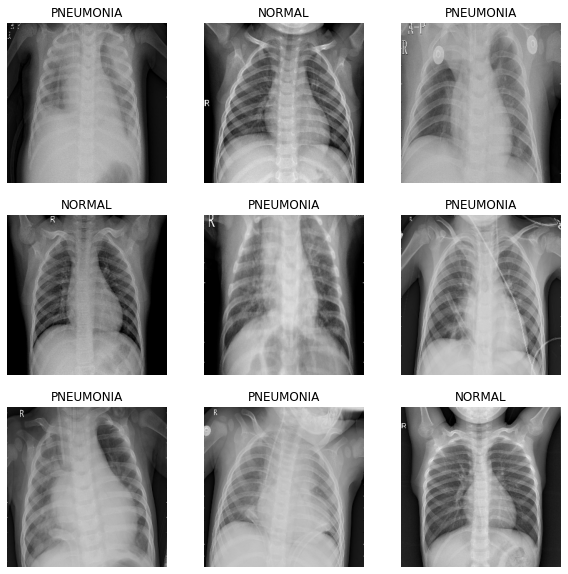

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Here we prefetch the data to prevent memory bottlenecks (no need to fit data into memory).

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [20]:
def pneumonia_model(image_shape = IMG_SIZE):
    """
    Defines a tf.keras model to perform binary classification on lungs infected with pneumonia. 
    Arguments:
        image_shape = image width and height (pre-specified)
    Returns:
        tf.keras.model
    """
    
    input_shape = image_shape + (3,)
    
    base = tf.keras.applications.EfficientNetB7(input_shape = input_shape,
                                               include_top = False,
                                               weights = 'imagenet')
    
    base.trainable = False
    
    inputs = tf.keras.Input(shape = input_shape)

    x = base(inputs, training=False)
    
    # new classification layers
    
    x = tfl.GlobalAveragePooling2D()(x)
    
    x = tfl.Dropout(0.3)(x)
    
    prediction_layer = tfl.Dense(1, activation = "linear")
    
    outputs = prediction_layer(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model
    

In [21]:
pneu_mod = pneumonia_model(IMG_SIZE)

We have now created a new model to perform binary classification based on the EfficientNetB7 pretrained imagenet CNN. We replaced the top layer with a global average pooling (to summarize info and generalize dims), dropout regularization (to prevent overfitting), and a single dense layer output for binary classification.

In [23]:
pneu_mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,248
Trainable params: 2,561
Non-trainable params: 64,097,687
_________________________________________________________________


In [25]:
base_lr = 0.001
pneu_mod.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_lr),
                loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                metrics = ['accuracy'])

In [27]:
initial_epochs = 5
history = pneu_mod.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
66/66 [==============================] - 125s 1s/step - loss: 0.3092 - accuracy: 0.8766 - val_loss: 0.1846 - val_accuracy: 0.9396
Epoch 2/5
66/66 [==============================] - 80s 1s/step - loss: 0.1799 - accuracy: 0.9422 - val_loss: 0.1384 - val_accuracy: 0.9521
Epoch 3/5
66/66 [==============================] - 81s 1s/step - loss: 0.1503 - accuracy: 0.9463 - val_loss: 0.1239 - val_accuracy: 0.9559
Epoch 4/5
66/66 [==============================] - 81s 1s/step - loss: 0.1308 - accuracy: 0.9521 - val_loss: 0.1119 - val_accuracy: 0.9588
Epoch 5/5
66/66 [==============================] - 81s 1s/step - loss: 0.1238 - accuracy: 0.9526 - val_loss: 0.1049 - val_accuracy: 0.9626


Here, on the validation set we can immediately see a very good accuracy in only 5 epochs. 

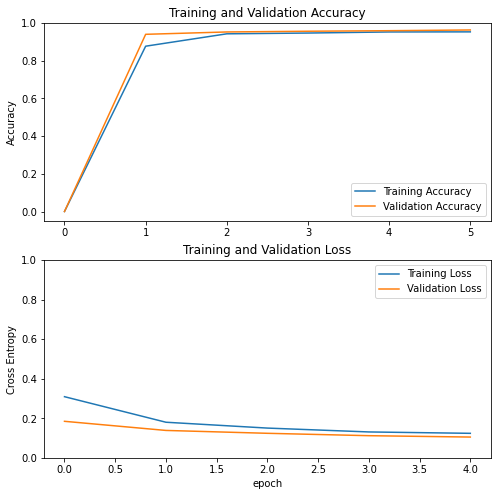

In [28]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

How well does the model do on new data?

In [29]:
test_dir = "Data/chest_xray/test"

test_dataset = image_dataset_from_directory(test_dir, shuffle=True)

Found 624 files belonging to 2 classes.


In [30]:
test_hist = pneu_mod.evaluate(test_dataset)

20/20 [==============================] - 15s 604ms/step - loss: 0.5055 - accuracy: 0.8285


Here our test accuracy is ~83% which is decent for an initial model. We could potentially increase effectiveness by retraining some of the higher-level layers to finer details specific for X-rays. Having a much higher validation accuracy suggests potential overfitting, but retraining the higher level layers and adding more regularization may help!

## Faster R-CNN Object Localization

## Brain MRI Abnormality Segmentation with U-Nets

Here I will implement a U-Net segmentation method for abnormality detection in brain MR images. This specific dataset requires labelling on masks that have and don't have manual FLAIR abnormalities segmented.

In [229]:
import re
import pandas as pd

In [230]:
mask = 'Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61B_19991127_9.tif'
suffix = '_mask.tif'
mask.endswith(suffix)

False

In [231]:
# Directory of images to run detection on
IMAGE_DIR = os.path.join("Data/brain_FLAIR_abnormalities/kaggle_3m")
data_paths = {'MR_image' : [], 'mask' : []}

suffix = '_mask.tif'

for root, dirs, files in os.walk(IMAGE_DIR):
    for name in files:
        path = os.path.join(root, name)
        if name.endswith(suffix):
            data_paths['mask'].append(path)
        elif name.endswith('.tif'):
            data_paths['MR_image'].append(path)

In [232]:
# organize image and masks in order
data_paths['MR_image'] = [path + '.tif' for path in sorted([re.sub('.tif', '', path) for path in data_paths['MR_image']])]
data_paths['mask'] =  [path + suffix for path in sorted([re.sub(suffix, '', path) for path in data_paths['mask']])]

In [233]:
data_paths = pd.DataFrame(data_paths)

In [234]:
data_paths.iloc[0][1]

'Data/brain_FLAIR_abnormalities/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_1_mask.tif'

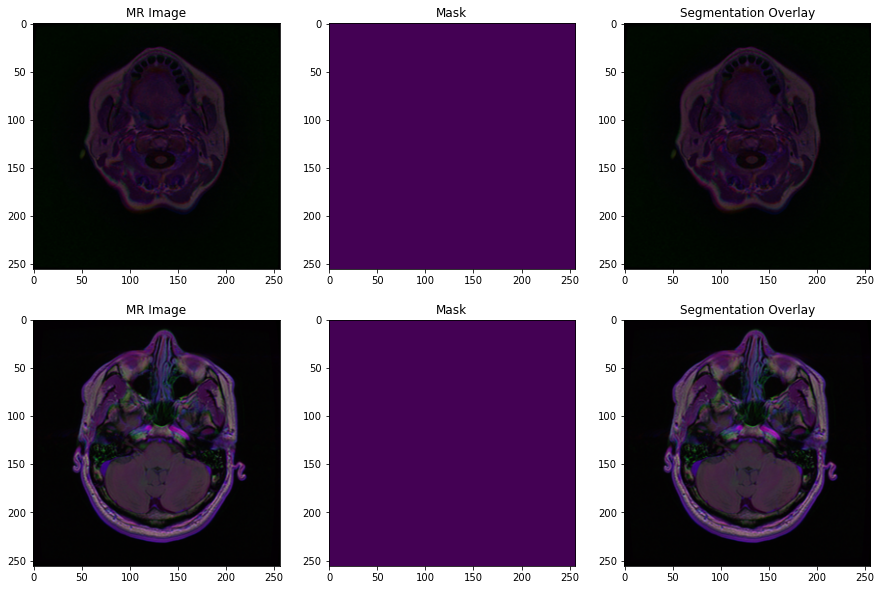

In [235]:
# view some images
plt.rcParams["figure.figsize"] = [15, 10]
f, ax=plt.subplots(2,3)
f.figsize = (10, 10)

for i in range(2):
    idx = np.random.randint(0, len(data_paths['mask'])) # get a random sample
    
    # brain scan
    MR = data_paths.iloc[idx, 0] 
    ax[i, 0].imshow(plt.imread(MR))
    ax[i, 0].set_title("MR Image")
    
    # segmentation mask
    mask = data_paths.iloc[idx, 1]
    ax[i, 1].imshow(plt.imread(mask))
    ax[i, 1].set_title("Mask")
    
    # overlay
    masked = np.ma.masked_where(plt.imread(mask) == 0, plt.imread(mask))
    ax[i, 2].imshow(plt.imread(MR))
    ax[i, 2].imshow(masked, 'jet')
    ax[i, 2].set_title("Segmentation Overlay")

In [236]:
def diagnose(path): 
    """
    Return 1 if there is a non-zero pixel in an image
    """
    A = plt.imread(path)
    if np.max(A) > 0:
        return "abnormality"
    else:
        return "none"

In [237]:
data_paths['Abnormality'] = data_paths['mask'].apply(diagnose) # label if there is an abnormality

In [238]:
data_paths.head()

,MR_image,mask,Abnormality
0,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,none
1,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,none
2,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,abnormality
3,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,abnormality
4,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,Data/brain_FLAIR_abnormalities/kaggle_3m\TCGA_...,abnormality


Now that we set up the image paths and the labels, we can start setting up the U-Net.

In [239]:
import tensorflow as tf
import numpy as np

import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization
import tensorflow.keras.callbacks  as cb
import tensorflow_io as tfio

import imageio
import cv2

In [240]:
image_filenames = tf.constant(data_paths["MR_image"])
masks_filenames = tf.constant(data_paths["mask"])

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(5):
    sample_image, sample_mask = image, mask
print(sample_image)
print(sample_mask)

tf.Tensor(b'Data/brain_FLAIR_abnormalities/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', shape=(), dtype=string)
tf.Tensor(b'Data/brain_FLAIR_abnormalities/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13_mask.tif', shape=(), dtype=string)


In [242]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path) # get path from tensorflow dataset
    img = tfio.experimental.image.decode_tiff(img) # decode .tif files
    img = tf.ensure_shape(img, (256, 256, 4)) # make sure RGBA channels (otherwise tensorflow can't parse)
    img = tf.image.convert_image_dtype(img, tf.float32) # standard float conversion
    img = tfio.experimental.color.rgba_to_rgb(img) # convert to RGB (don't need alpha channel - all 1's)

    mask = tf.io.read_file(mask_path)
    mask = tfio.experimental.image.decode_tiff(mask)
    mask = tf.ensure_shape(mask, (256, 256, 4))
    mask = tfio.experimental.color.rgba_to_rgb(mask)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    
    input_mask /= 255

    return input_image, input_mask

# process data
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [244]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(256, 256, 3)
(256, 256, 1)


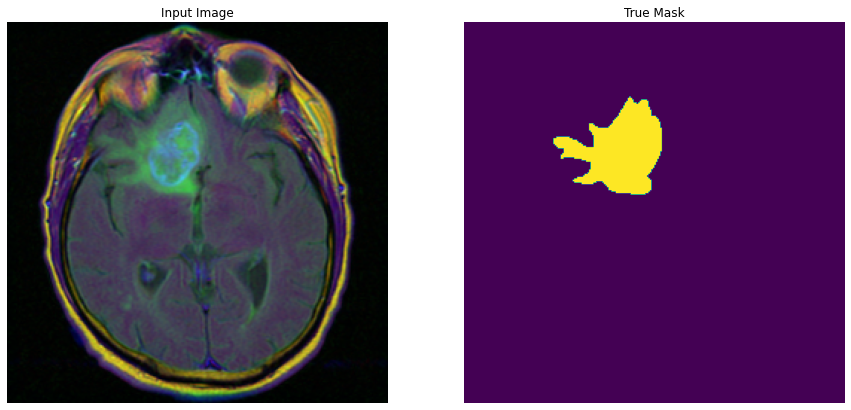

(96, 128, 3)
(96, 128, 1)


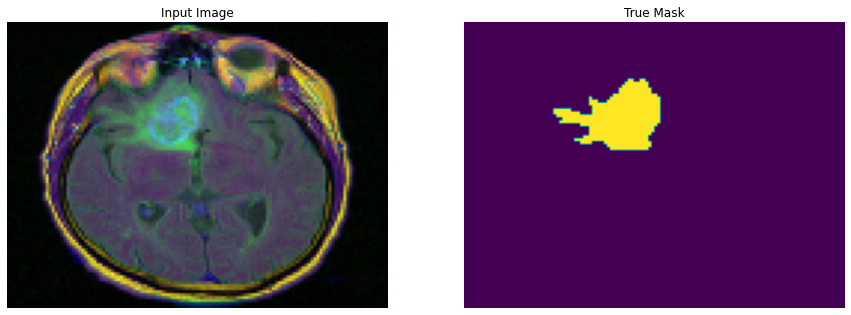

In [245]:
idx = 4 #np.random.randint(0, len(data_paths['mask']))

for image, mask in image_ds.take(idx):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])


for image, mask in processed_image_ds.take(idx):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [329]:
def conv(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True, batchnorm = True):

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    
    if batchnorm:
        conv = BatchNormalization()(conv)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if batchnorm:
        conv = BatchNormalization()(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2, 2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [330]:
def upsample(expansive, contractive, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive)
    
    merge = concatenate([up, contractive], axis=3)
    
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [343]:
def unet(input_size = (96, 128, 3), n_filters = 32, n_classes = 1):
    inputs = Input(input_size)
    
    # Encoding
    c1 = conv(inputs, n_filters)
    c2 = conv(c1[0], n_filters*2) # get the next layer
    c3 = conv(c2[0], n_filters*4)
    c4 = conv(c3[0], n_filters*8, dropout_prob = 0.3)
    c5 = conv(c4[0], n_filters*16, dropout_prob = 0.3, max_pooling = False)
    
    # Decoding
    u1 = upsample(c5[0], c4[1], n_filters*8) # get information from c4 skip layer
    u2 = upsample(u1, c3[1], n_filters*4)
    u3 = upsample(u2, c2[1], n_filters*2)
    u4 = upsample(u3, c1[1], n_filters)
    
    # back to image
    final1 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same')(u4)
    
    final2 = Conv2D(1, 1, padding='same', activation = 'sigmoid')(final1)
    
    # model
    model = tf.keras.Model(inputs = inputs, outputs = final2)
    return model

In [344]:
img_height = 96
img_width = 128
num_channels = 3

brain_mod = unet((img_height, img_width, num_channels))

In [345]:
brain_mod.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_241 (Conv2D)             (None, 96, 128, 32)  896         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 96, 128, 32)  128         conv2d_241[0][0]                 
__________________________________________________________________________________________________
conv2d_242 (Conv2D)             (None, 96, 128, 32)  9248        batch_normalization_70[0][0]     
___________________________________________________________________________________________

In [346]:
brain_mod.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                 metrics = ['accuracy'])

In [347]:
int(0.1*tf.data.experimental.cardinality(processed_image_ds).numpy())

392

In [348]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)

# splits
#split = int(0.1*tf.data.experimental.cardinality(processed_image_ds).numpy())
#test_dataset = processed_image_ds.take(split)#.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_dataset = processed_image_ds.skip(split)
#val_dataset = train_dataset.take(split)#.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_dataset = train_dataset.skip(split)

train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_dataset = train_dataset#.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(processed_image_ds.element_spec)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.float32, name=None))


In [349]:
print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(val_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())

123
392
392


In [350]:
cbs = [
    cb.EarlyStopping(monitor = 'loss', patience = 5, verbose = 1),
    cb.ReduceLROnPlateau(monitor = 'loss', patience = 5, verbose = 1),
    cb.ModelCheckpoint('brain_unet.h5', monitor = 'loss', save_best_only=True, save_weights_only = True, verbose = 1)
]

In [351]:
model_history = brain_mod.fit(train_dataset,
                              epochs=EPOCHS, 
                              callbacks = cbs
                              )

Epoch 1/40
123/123 [==============================] - 43s 311ms/step - loss: 0.0332 - accuracy: 0.9894

Epoch 00001: loss improved from inf to 0.03322, saving model to brain_unet.h5
Epoch 2/40
123/123 [==============================] - 18s 148ms/step - loss: 0.0242 - accuracy: 0.9922

Epoch 00002: loss improved from 0.03322 to 0.02418, saving model to brain_unet.h5
Epoch 3/40
123/123 [==============================] - 18s 147ms/step - loss: 0.0215 - accuracy: 0.9932

Epoch 00003: loss improved from 0.02418 to 0.02153, saving model to brain_unet.h5
Epoch 4/40
123/123 [==============================] - 18s 148ms/step - loss: 0.0208 - accuracy: 0.9932

Epoch 00004: loss improved from 0.02153 to 0.02078, saving model to brain_unet.h5
Epoch 5/40
123/123 [==============================] - 18s 147ms/step - loss: 0.0201 - accuracy: 0.9932

Epoch 00005: loss improved from 0.02078 to 0.02015, saving model to brain_unet.h5
Epoch 6/40
123/123 [==============================] - 19s 151ms/step - los

In [353]:
def learning_curves(history):
    acc = [0.] + history.history['accuracy']

    loss = history.history['loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training Loss')
    plt.xlabel('epoch')
    plt.show()

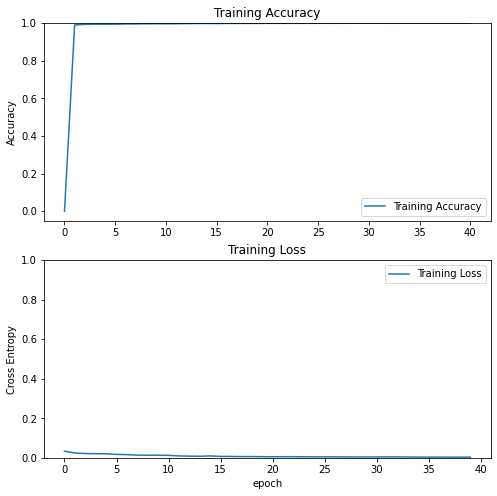

In [354]:
learning_curves(model_history)

In [546]:
# pick a sample
for image, mask in train_dataset.take(15): 
    sample_image, sample_mask = image, mask
sample_pred = brain_mod.predict(sample_image)    

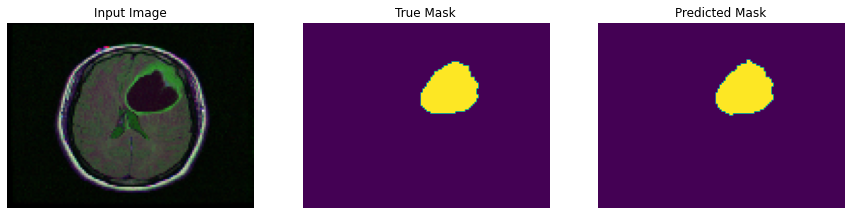

In [547]:
 display([sample_image[0], sample_mask[0], np.rint(sample_pred[0])])

Here we can see that we can segment the brain abnormality relatively well! It would help to further optimize by perhaps working with validation and testing sets (as they were not applied here so the model may be overfitting). However, this still shows the potential usefulness of having automated segmentation to detect MRI abnormalities.

## Mask R-CNN [MRCNN - TF/Keras](https://github.com/matterport/Mask_RCNN)

Mask R-CNN builds on R-CNN (object localization) by adding a mask. This implementation specifically uses this [verson](https://github.com/leekunhee/Mask_RCNN) adapted for TensorFlow 2 functionality.

In [ ]:
# Helpers
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Setup
ROOT_DIR = os.path.abspath("Segmentation/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

%matplotlib inline

In [ ]:
class BrainConfig(Config):
    """
    Custom configuration for brain abnormality segmentation training.
    """
    # name config
    NAME = "brain"
    
    # 6 GB VRAM
    IMAGES_PER_GPU = 2
    
    # Classes
    NUM_CLASSES = 1 + 1 # background & abnormality
    
    # Training steps per epoch
    STEPS_PER_EPOCH = 100

config = BrainConfig()
config.display()

## References

1. [Andrew Ng's deep learning specialization (CNNs)](https://www.coursera.org/learn/convolutional-neural-networks/home/welcome)
2. [Microsoft COCO: Common Objects in Context, Lin et. al.](https://arxiv.org/pdf/1405.0312.pdf)
3. [Mask R-CNN, He et. al.](https://arxiv.org/pdf/1703.06870.pdf)
4. [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning, Kermany et. al.](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)
6. [Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm. Mateusz Buda, et al.](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)